# Object Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import models, layers, utils, backend
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt

import numpy as np
import os

In [3]:
# parameter yang digunakan
img_size = (299, 299, 3)
img_dir = "../subset_stanford_online_products"
batch_size = 16

lr_classifier = 1e-4
epoch_classifier = 10

# learning rate untuk fine tuning perlu diset kecil agar tidak merusak bobot yang sudah terbentuk
lr_tuning = 1e-6
epoch_tuning = 12

## Prepare Dataset

Dataset umumnya akan dilakukan augmentasi dan normalisasi nilai citra masukan. Perintah `rescale = 1. / 255` akan menormalisasi nilai citra masukan dari rentang 0 sampai 255 menjadi rentang 0 sampai 1.

In [4]:
train_datagen = image.ImageDataGenerator(
    # rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2)

# Note that the validation data should not be augmented!
test_datagen = image.ImageDataGenerator(
    # rescale=1. / 255,
    validation_split=0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    img_dir,
    subset="training",
    # All images will be resized to 299 x 299
    target_size=img_size[:2],
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
    shuffle=True,
    seed=1234)

validation_generator = test_datagen.flow_from_directory(
    img_dir,
    subset="validation",
    target_size=img_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=1234)

Found 9600 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


Pada model transfer learning disediakan [preprocess_input](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/applications/xception). Mari kita lihat apa yang `preprocess_input` lakukan

In [6]:
im_list = os.listdir(os.path.join(img_dir, "bicycle_final"))
im_list[:3]

['400931080828_7.JPG', '321820322214_3.JPG', '161777354031_4.JPG']

In [7]:
fpath = os.path.join(img_dir, "bicycle_final/380799727502_0.JPG")

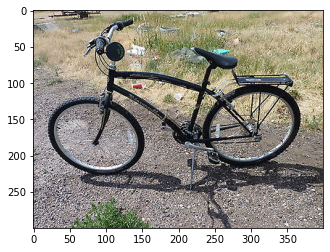

In [8]:
im = image.load_img(fpath)
plt.imshow(im)

In [9]:
im_array = image.img_to_array(im)
im_array.max(), im_array.min(), im_array.mean()

(255.0, 0.0, 128.71721)

In [10]:
preprocess_input(im_array)
im_array.max(), im_array.min(), im_array.mean()

(1.0, -1.0, 0.0095468)

### Take away:

1. [Kenali normalisasi model pre-trained:](https://github.com/keras-team/keras-applications/tree/master/keras_applications)
    - caffe: will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling. Contoh model : vgg, resnet, resnet50
    - tf: will scale pixels between -1 and 1, sample-wise. Contoh model : inception, xception, mobilenet, nasnet, resnet_v2
    - torch: will scale pixels between 0 and 1 and then will normalize each channel with respect to the ImageNet dataset. Contoh model : densenet, efficientnet, resnext
   
   
2. Pengalaman pribadi pada model Inception / Xception dengan metode `rescale=1./255` dibandingkan `preprocess_input` tidak memberikan dampak yang signifikan terhadap model. Pilih salah satu, apakah gunakan `preprocess_input`, atau `rescale = 1. / 255`, jangan keduanya.

Pada sesi kali ini saya akan gunakan `preprocess_input`.

## Cek Training Dataset

In [11]:
train_generator[0][0].shape

(16, 299, 299, 3)

In [12]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

10

In [13]:
fname = train_generator.filenames[image_idx]
fname

'table_final/301420675267_2.JPG'

In [14]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(16, 299, 299, 3)
(16, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

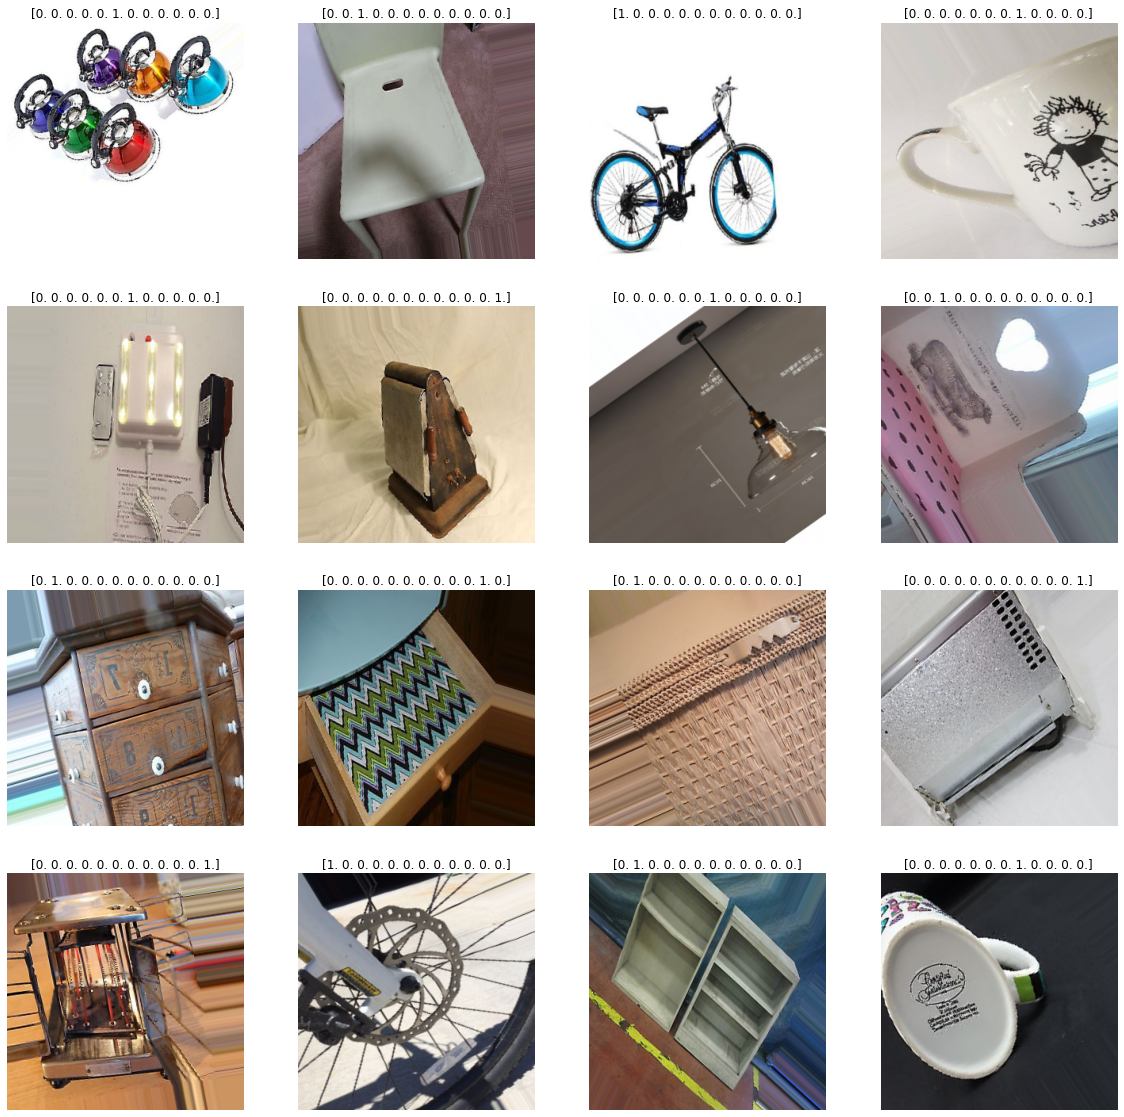

In [15]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Cek Validation Dataset

In [16]:
validation_generator[0][0].shape

(16, 299, 299, 3)

In [17]:
image_idx = validation_generator.index_array[1]
validation_generator.labels[image_idx]

1

In [18]:
fname = validation_generator.filenames[image_idx]
fname

'cabinet_final/141622830935_2.JPG'

In [19]:
validation_images_7, validation_labels_7 = validation_generator[7]
print(validation_images_7.shape)
print(validation_labels_7.shape)

(16, 299, 299, 3)
(16, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

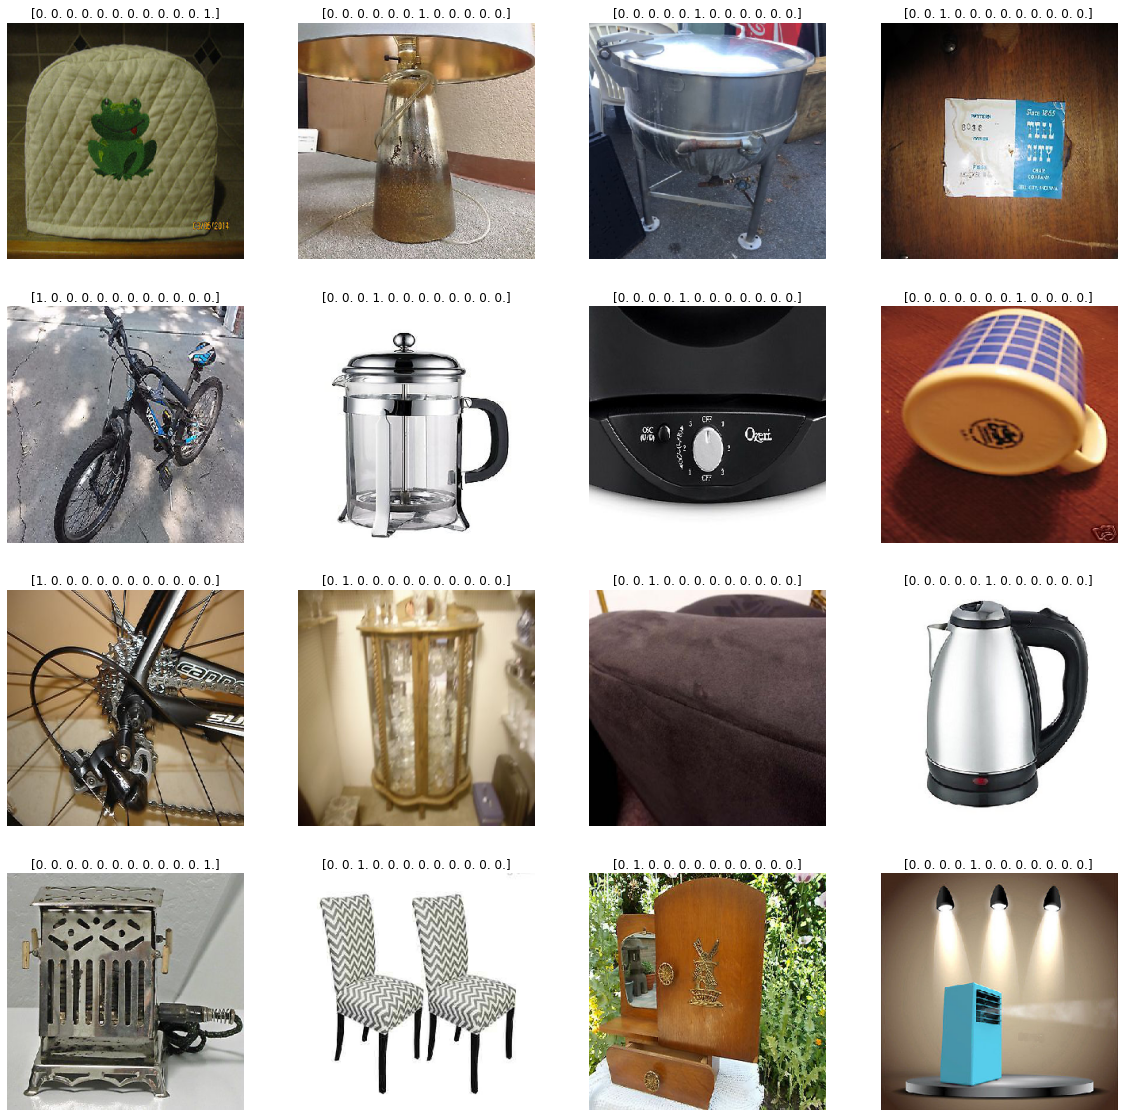

In [20]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(validation_images_7[idx]))
    plt.title(str(validation_labels_7[idx]))
    plt.axis('off')

plt.show

## Define Model with multi GPU

Pada bagian ini kita akan mendefinisikan susunan arsitektur yang digunakan. Bagian convolution akan menggunakan arsitektur Xception. Sedangkan bagian classifier bisa kita custom ataupun mengikuti arsitektur yang framework Keras sudah sediakan.

In [21]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### Keras Classifier

In [22]:
def create_model_keras():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [23]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_keras()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588     
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
____________________________________________

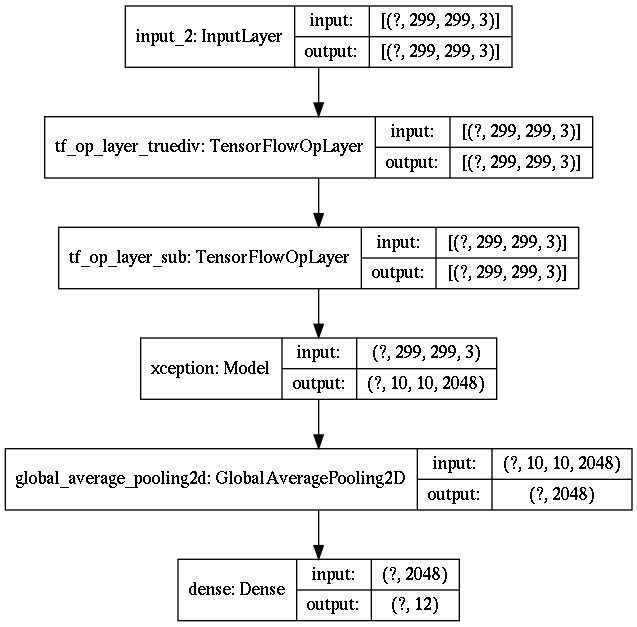

In [25]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Fastai classifier

In [26]:
def create_model_fastai():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(2048, activation="relu")(x)
    # x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [27]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_fastai()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

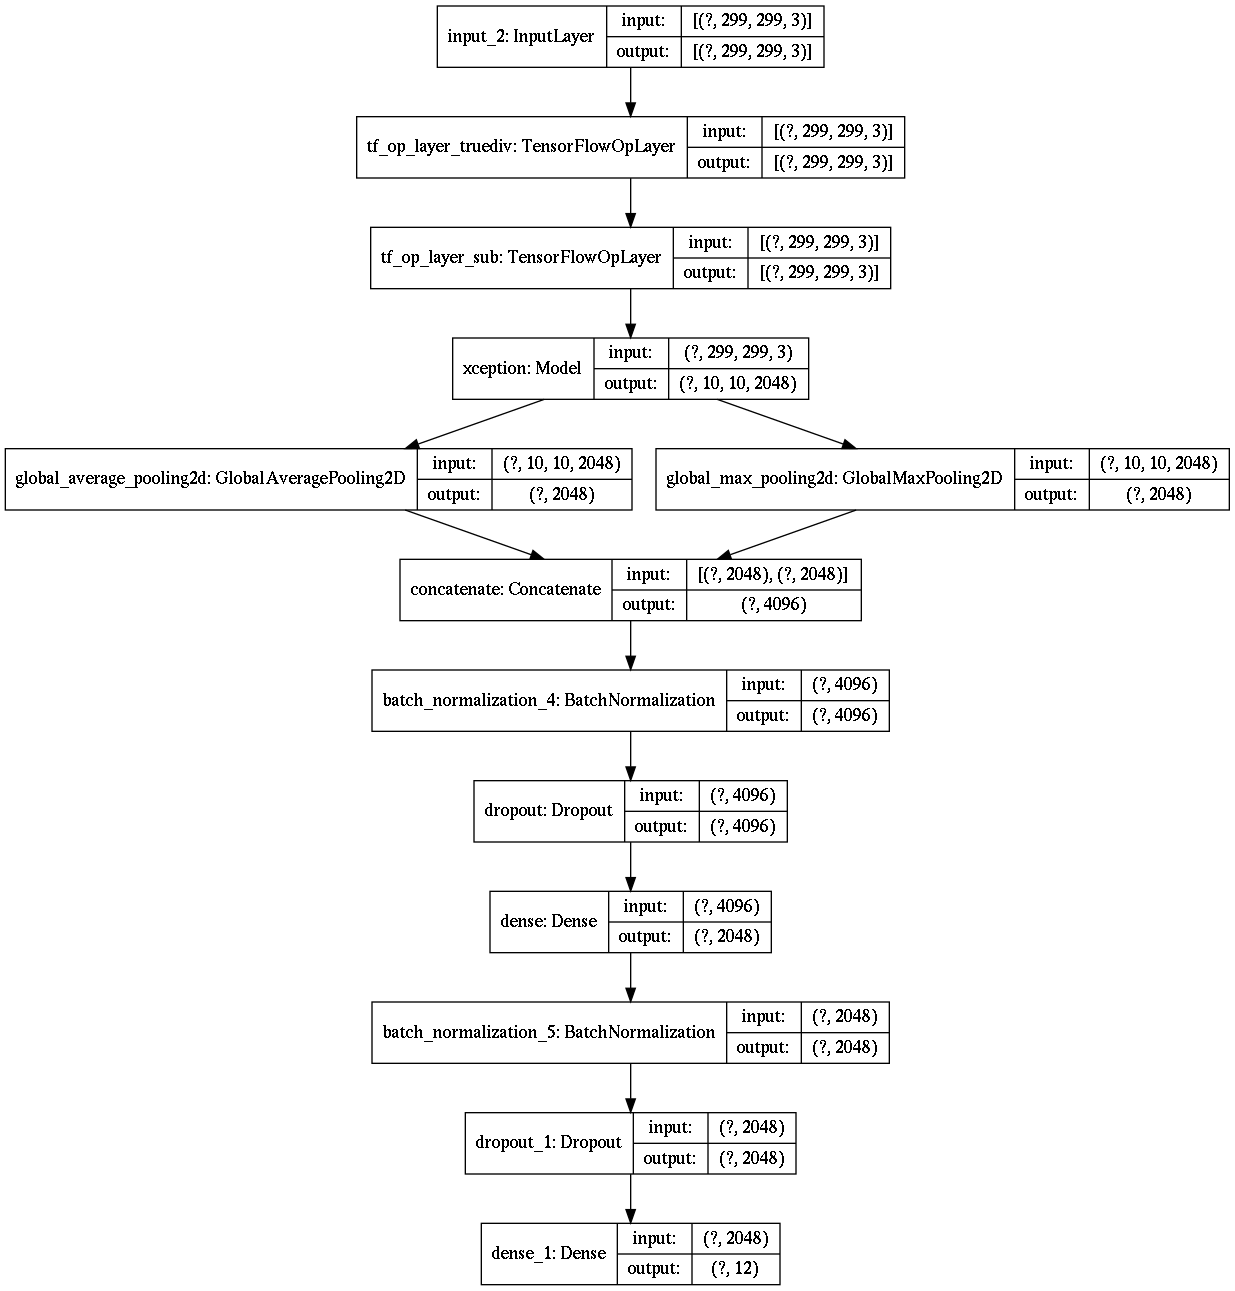

In [29]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Sazzad classifier

In [30]:
# sumber: https://dl.acm.org/doi/10.1145/3377049.3377067
def create_model_sazzad():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [31]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_fastai()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

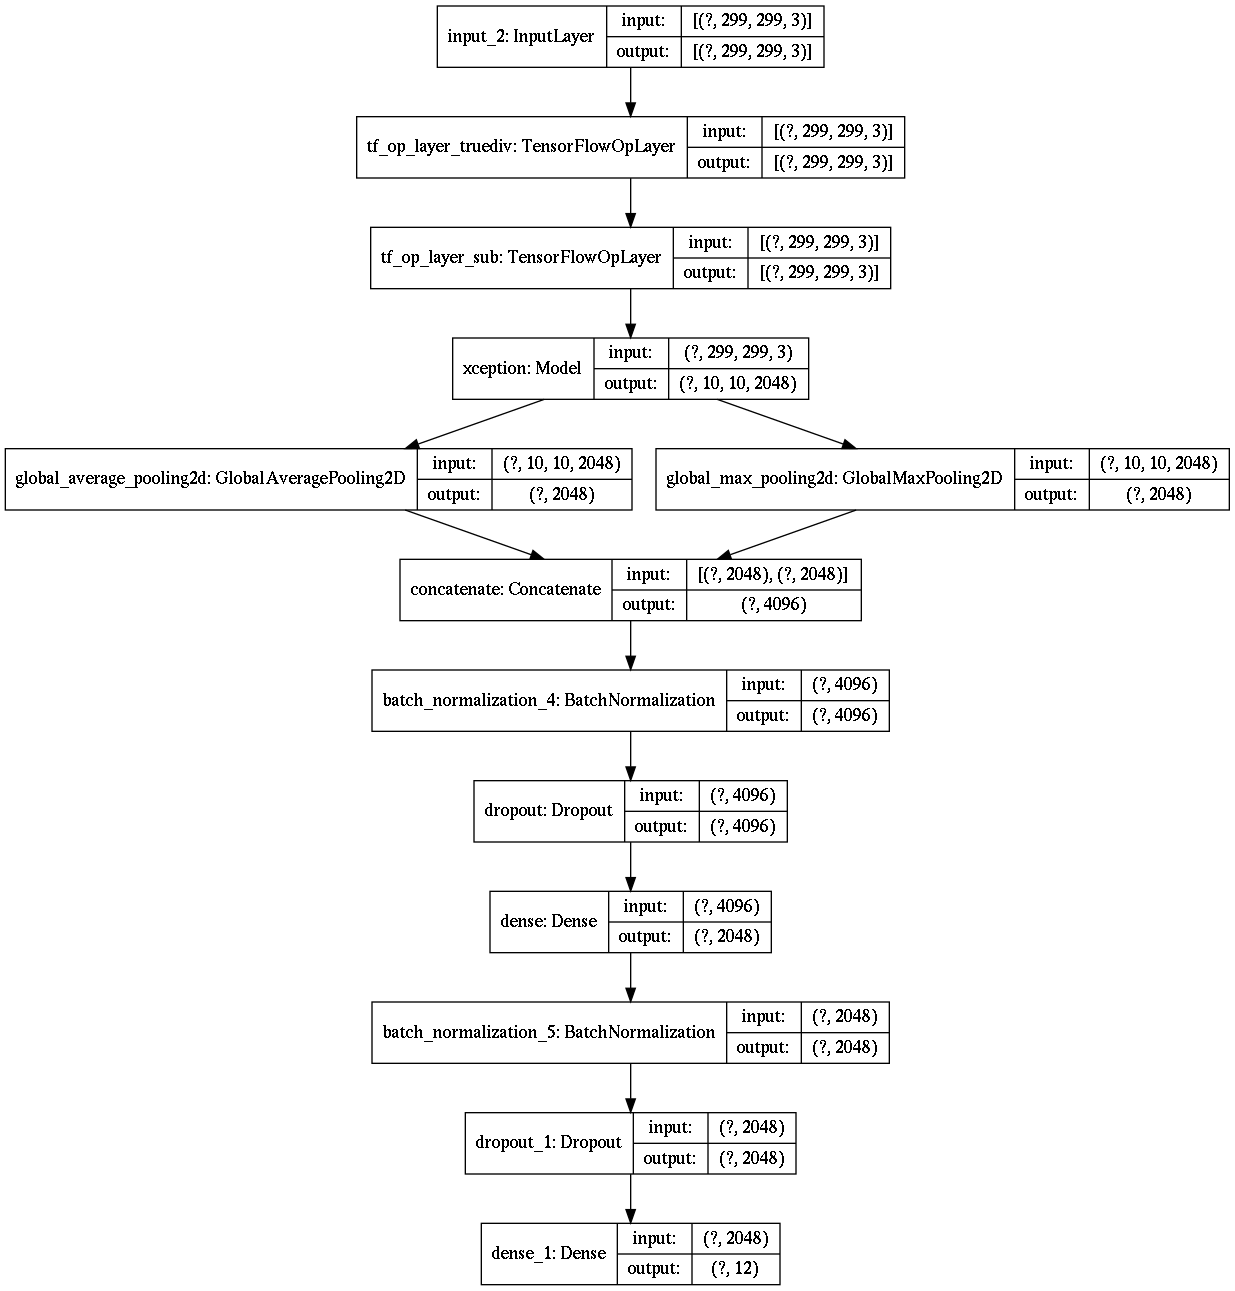

In [33]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Take away: 

Q : Bagaimana memilih arsitektur classifier?

A : Bisa pakai arsitektur classifier bawaan dari Keras / framework lain seperti fastai. Bisa juga ikuti arsitektur yang dipakai pada jurnal-jurnal sesuai studi yang sedang dilakukan.

Pada sesi kali ini saya akan menggunakan classifier fastai

In [34]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_fastai()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

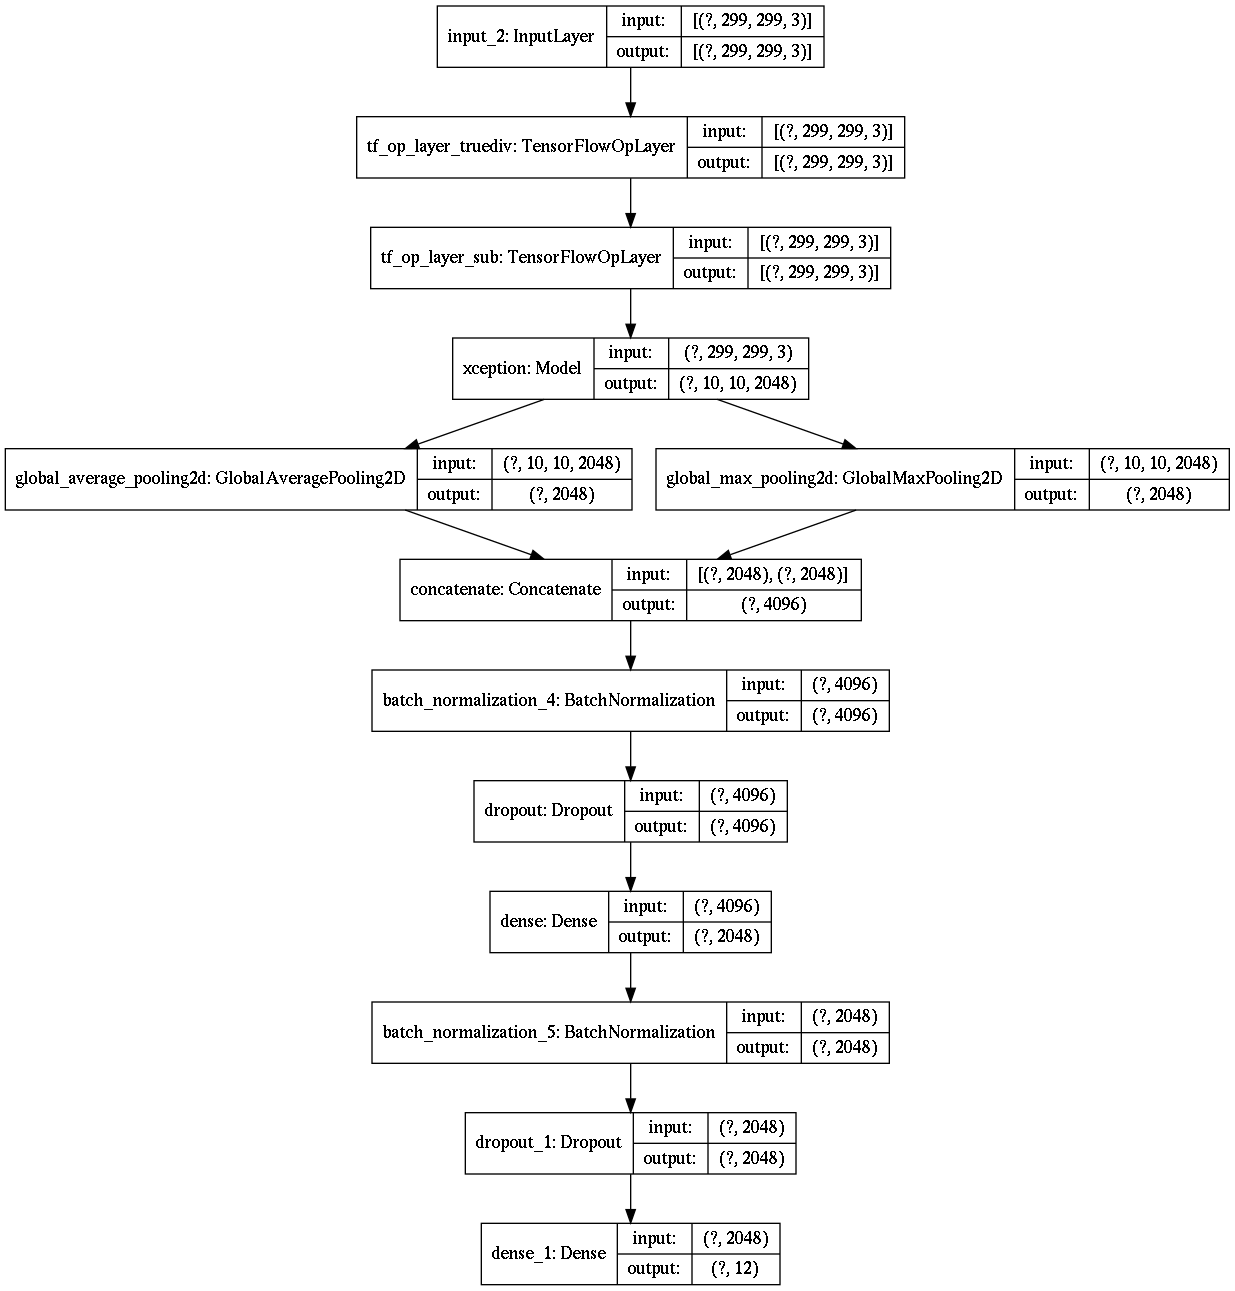

In [36]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Training Clasifier

In [37]:
%%time
history = model.fit(train_generator,
                    epochs=epoch_classifier,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 600 steps, validate for 150 steps
Epoch 1/10
600/600 [==============================] - 146s 244ms/step - loss: 1.6083 - categorical_accuracy: 0.5849 - val_loss: 0.8758 - val_categorical_accuracy: 0.7650
Epoch 2/10
600/600 [==============================] - 140s 233ms/step - loss: 1.2655 - categorical_accuracy: 0.6614 - val_loss: 0.8610 - val_categorical_accuracy: 0.7742
Epoch 3/10
600/600 [==============================] - 140s 233ms/step - loss: 1.1249 - categorical_accuracy: 0.6916 - val_loss: 0.8188 - val_categorical_accuracy: 0.7671
Epoch 4/10
600/600 [==============================] - 140s 233ms/step - loss: 1.0422 - categorical_accuracy: 0.7000 - val_loss: 0.7988 - val_categorical_accuracy: 0.7846
Epoch 5/10
600/600 [==============================] - 140s 233ms/step - loss: 0.9474 - categorical_accuracy: 0.7228 - val_loss: 0.7792 - val_categorical_accuracy: 0.7788
Epoch 6/10
600/600 [==============================] - 14

In [38]:
model.metrics_names

['loss', 'categorical_accuracy']

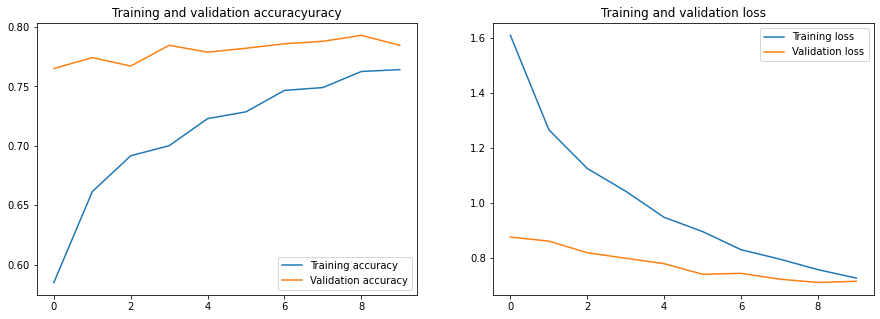

In [39]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [40]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
150/150 [==============================] - 18s 122ms/step - loss: 0.7153 - categorical_accuracy: 0.7846


[0.7152968448897202, 0.78458333]

In [41]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [42]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

150/150 [==============================] - 18s 119ms/step


In [43]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.99      0.95      0.97       200
     cabinet       0.79      0.87      0.83       200
       chair       0.77      0.61      0.68       200
 coffe_maker       0.76      0.78      0.77       200
         fan       0.75      0.81      0.78       200
      kettle       0.84      0.79      0.81       200
        lamp       0.71      0.71      0.71       200
         mug       0.84      0.93      0.88       200
        sofa       0.82      0.88      0.85       200
     stapler       0.83      0.71      0.77       200
       table       0.59      0.59      0.59       200
     toaster       0.74      0.78      0.76       200

    accuracy                           0.78      2400
   macro avg       0.79      0.78      0.78      2400
weighted avg       0.79      0.78      0.78      2400



In [44]:
model.save("transfer_learning_classifier.h5")

## Fine tuning

In [45]:
conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'add_7':
#         set_trainable = True

#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [46]:
with strategy.scope():
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_tuning),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=[metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [47]:
%%time
history = model.fit(train_generator,
                    epochs=epoch_tuning,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 600 steps, validate for 150 steps
Epoch 1/12
600/600 [==============================] - 361s 602ms/step - loss: 0.6289 - categorical_accuracy: 0.7885 - val_loss: 0.7053 - val_categorical_accuracy: 0.7867
Epoch 2/12
600/600 [==============================] - 353s 588ms/step - loss: 0.6171 - categorical_accuracy: 0.7962 - val_loss: 0.6938 - val_categorical_accuracy: 0.7900
Epoch 3/12
600/600 [==============================] - 353s 588ms/step - loss: 0.5934 - categorical_accuracy: 0.7999 - val_loss: 0.6894 - val_categorical_accuracy: 0.7929
Epoch 4/12
600/600 [==============================] - 353s 588ms/step - loss: 0.6150 - categorical_accuracy: 0.7978 - val_loss: 0.6827 - val_categorical_accuracy: 0.7971
Epoch 5/12
600/600 [==============================] - 354s 589ms/step - loss: 0.5795 - categorical_accuracy: 0.8036 - val_loss: 0.6801 - val_categorical_accuracy: 0.7954
Epoch 6/12
600/600 [==============================] - 35

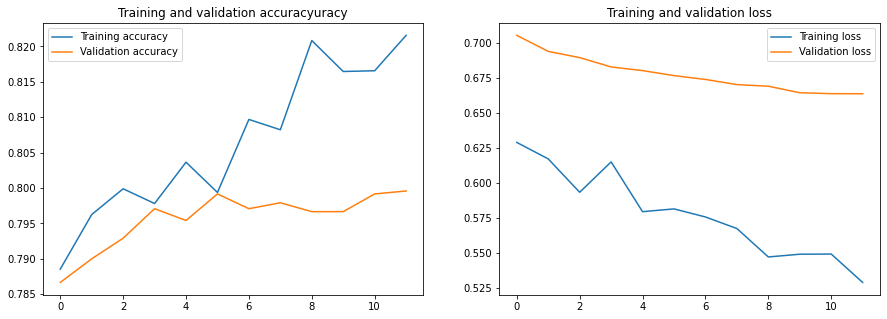

In [48]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [49]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
150/150 [==============================] - 19s 124ms/step - loss: 0.6636 - categorical_accuracy: 0.7996


[0.6636130514740944, 0.7995833]

In [50]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [51]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

150/150 [==============================] - 18s 120ms/step


In [52]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.99      0.96      0.98       200
     cabinet       0.80      0.87      0.83       200
       chair       0.74      0.66      0.70       200
 coffe_maker       0.76      0.81      0.78       200
         fan       0.78      0.83      0.80       200
      kettle       0.82      0.80      0.81       200
        lamp       0.79      0.73      0.76       200
         mug       0.86      0.93      0.89       200
        sofa       0.82      0.86      0.84       200
     stapler       0.82      0.78      0.80       200
       table       0.63      0.59      0.61       200
     toaster       0.77      0.78      0.77       200

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



In [53]:
model.save("transfer_learning_fine_tune.h5")

###  Take away:

- Fine tuning bisa dilakukan dari layer manapun.
- Fine tuning umumnya direkomendasikan pada bagian deeper layer karena layer-layer ini mengekstrak fitur yang spesifik dari dataset. Misal model pre-trained dilatih untuk mengenali citra kuda, maka deeper layer akan memiliki fitur khas kuda.
- Lakukan eksplorasi untuk mendapatkan jumlah layer yang perlu di-fine tuning

![](https://cdn-images-1.medium.com/max/1600/0*EIydzfpUhIatV9gU.)